# Example 004: Transverse wake extrapolation of SPS Transitions
> Using directly the time domain wake data

This example features simulated wakefield data of the "SPS - transition" model.

The transition component in the SPS is included in the transverse impedance model for the SPS and is introduced to test the extrapolation capability of the evolutionary algorithm on a more elaborate problem. This case is particularly interesting as the impedance model only contains 16.66 ns of transverse wake potential data and is not fully decayed.

This example will use only the wake data in time domain to perform the fitting and extrapolation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import iddefix
from scipy.constants import c as c_light

### Import data & visualize the data

In [2]:
# Importing wake potential data
data_wake_potential = np.loadtxt(
    "examples/data/004_SPS_model_transitions_q26.txt", comments="#", delimiter="\t"
)

# Extracting data
data_wake_time = data_wake_potential[:, 0] * 1e-9  # [s]
data_wake_dipolar = data_wake_potential[:, 2]

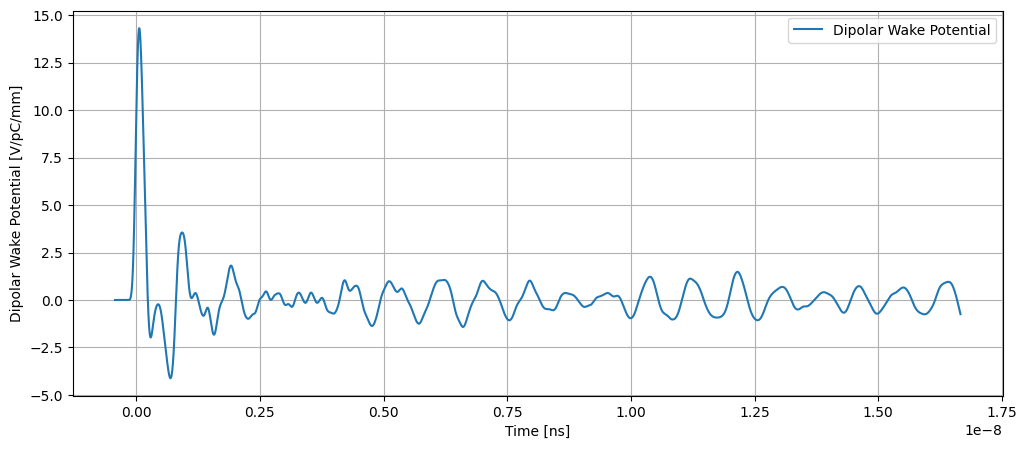

In [3]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Plot data_wake_time vs data_wake_dipolar on the left
ax.plot(data_wake_time, data_wake_dipolar, label="Dipolar Wake Potential")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Dipolar Wake Potential [V/pC/mm]")
ax.grid(True)
ax.legend()

## Using the wake function for fitting

### Decimate the data to improve speed

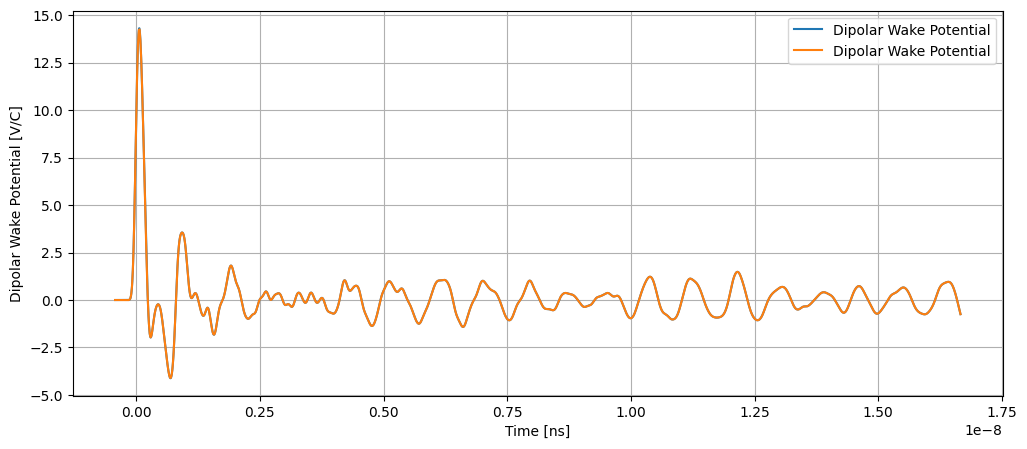

In [4]:
# Decimate wake data
x = np.linspace(data_wake_time[0], data_wake_time[-1], 1000)
y = np.interp(x, data_wake_time, data_wake_dipolar)

# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Plot data_wake_time vs data_wake_dipolar on the left
ax.plot(data_wake_time, data_wake_dipolar, label="Dipolar Wake Potential")
ax.plot(x, y, label="Dipolar Wake Potential")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Dipolar Wake Potential [V/C]")
ax.grid(True)
ax.legend()

data_wake_time = x
data_wake_dipolar = y

### Using SmartBoundDetermination on Impedance

To find the parameter bounds for the Evolutionary Algorithm, it is very usefull to look at the impedance and use the `SmartBoundDetermination` class to generate the parameter bounds. 

Since we are considering the data a **Wake function**, the impedance is simply the fft, that iddefix provides throught the `compute_fft` routine:

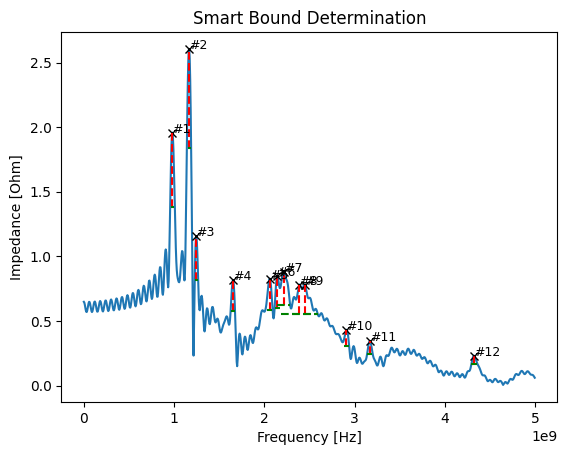

In [5]:
f, Z = iddefix.compute_fft(data_wake_time, data_wake_dipolar, fmax=5e9)

heights = np.zeros_like(Z)
heights[f < 1.5e9] = 1.1
heights[f >= 1.5e9] = 0.6
heights[f >= 2.0e9] = 0.7
heights[f >= 2.9e9] = 0.4
heights[f >= 3e9] = 0.3
heights[f >= 4e9] = 0.2
bounds = iddefix.SmartBoundDetermination(f, np.abs(Z), minimum_peak_height=heights)
bounds.inspect()

#### Running IDDEFIX DE
Running the DE algorithm with IDDEFIX and chosen parameters. The default `FitFunction` uses the impedance. To use the wake, simply modify the parameter to the desired fit function mode:
- impedance
- wake or wake function
- wake potential

In [6]:
%%time
DE_model = iddefix.EvolutionaryAlgorithm(
    data_wake_time,
    data_wake_dipolar * c_light,  # remove normalization
    N_resonators=bounds.N_resonators,
    parameterBounds=bounds.parameterBounds,
    plane="transverse",
    fitFunction="wake function",  # accpts also 'wake'
    objectiveFunction=iddefix.ObjectiveFunctions.sumOfSquaredErrorReal,
)

# Run the differential evolution
DE_model.run_differential_evolution(
    maxiter=200, popsize=180, tol=0.001, mutation=(0.1, 0.5), crossover_rate=0.8
)
print(DE_model.warning)

Optimization Progress %:  11%|█         | 11.182709243553557/100 [04:40<37:05, 25.06s/it]    



----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        1.75e+00        |      70.19       |    9.920e+08     
    2     |        4.52e+00        |      91.79       |    1.175e+09     
    3     |        1.03e+00        |      21.95       |    1.257e+09     
    4     |        6.93e-01        |      45.69       |    1.657e+09     
    5     |        7.21e-01        |      184.67      |    2.067e+09     
    6     |        6.82e-01        |      162.88      |    2.148e+09     
    7     |        7.70e-01        |      76.40       |    2.222e+09     
    8     |        6.44e-01        |       2.96       |    2.396e+09     
    9     |        6.32e-01        |      36.94       |    2.457e+09     
    10    |        4.89e-01        |      113.10      |    2.905e+09     
    11    |        3.55e-01        |      

In [7]:
DE_model.run_minimization_algorithm()

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        1.86e+00        |      63.39       |    1.006e+09     
    2     |        4.70e+00        |      94.18       |    1.176e+09     
    3     |        1.01e+00        |      19.98       |    1.268e+09     
    4     |        7.36e-01        |      44.84       |    1.657e+09     
    5     |        7.17e-01        |      180.60      |    2.074e+09     
    6     |        7.43e-01        |      178.73      |    2.200e+09     
    7     |        7.29e-01        |      79.29       |    2.248e+09     
    8     |        5.80e-01        |       2.67       |    2.625e+09     
    9     |        5.76e-01        |      38.70       |    2.432e+09     
    10    |        4.40e-01        |      123.54      |    2.907e+09     
    

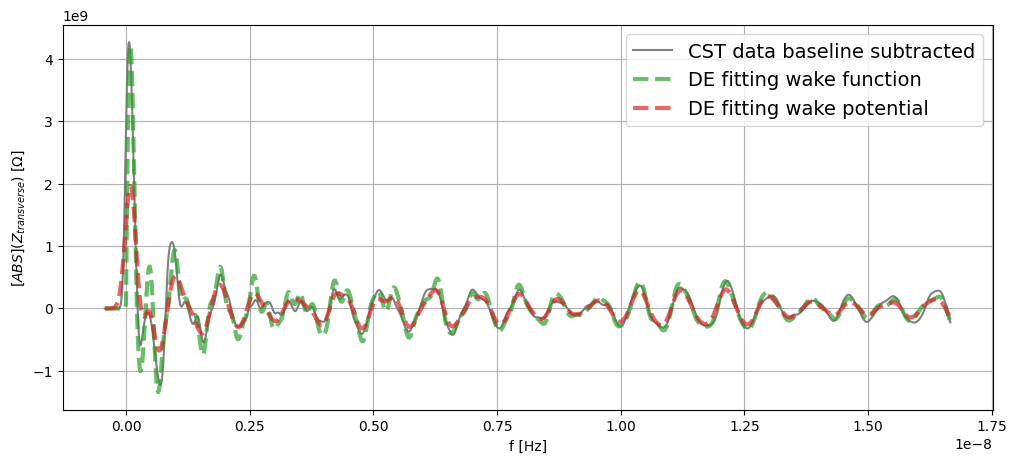

In [8]:
# Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12, 5))

ax0.plot(
    DE_model.time_data, DE_model.wake_data, "grey", label="CST data baseline subtracted"
)

ax0.plot(
    data_wake_time,
    DE_model.get_wake(data_wake_time),
    lw=3,
    c="tab:green",
    linestyle="--",
    label="DE fitting wake function",
    alpha=0.7,
)

ax0.plot(
    data_wake_time,
    DE_model.get_wake_potential(data_wake_time, sigma=1e-10),
    lw=3,
    c="tab:red",
    linestyle="--",
    label="DE fitting wake potential",
    alpha=0.7,
)


ax0.set_xlabel("f [Hz]")
ax0.set_ylabel("$[ABS](Z_{transverse})$ [$\Omega$]")
ax0.legend(loc="best", fontsize=14)
ax0.grid()

### Using analytical wake and impedance from DE parameters

Use the fully decayed wake and impedance functions in `iddefix`'s Resonator formalism to see the extrapolated resoults

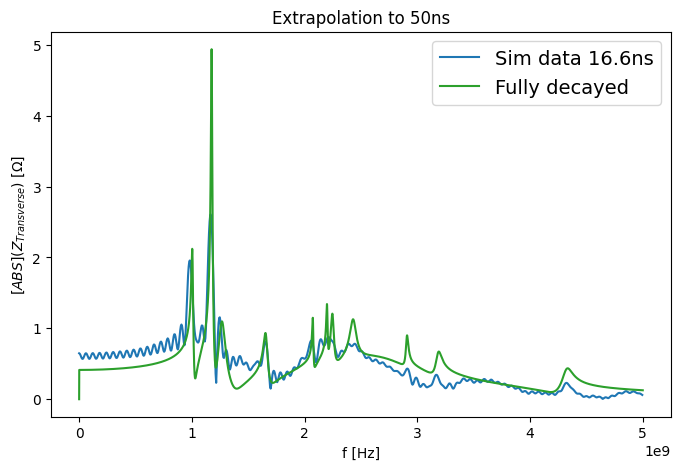

In [9]:
f_fd = np.linspace(0, 5e9, 10000)
Z_fd = DE_model.get_impedance(frequency_data=f_fd)

# Compare magnitude [ABS]
plt.figure(figsize=(8, 5))
plt.plot(f, np.abs(Z), label="Sim data 16.6ns")
plt.plot(f_fd, np.abs(Z_fd), color="tab:green", label="Fully decayed")
plt.legend()
plt.title("Extrapolation to 50ns")
plt.xlabel("f [Hz]")
plt.ylabel("$[ABS](Z_{Transverse})$ [$\Omega$]")
plt.legend(loc="best", fontsize=14)

ax0.set_xlim(0.1e9, 3e9)
ax0.grid()

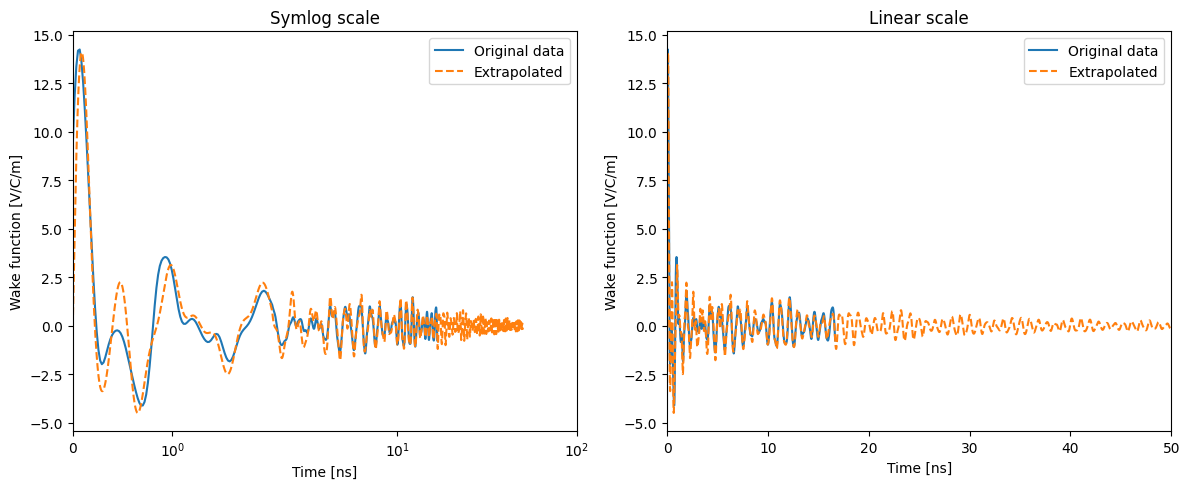

In [10]:
time_ext = np.linspace(data_wake_time[0], 50e-9, 100000)
total_wake = DE_model.get_wake(time_ext) / c_light

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot with symlog scale on the left
axs[0].plot(data_wake_time * 1e9, data_wake_dipolar, label="Original data")
axs[0].plot(time_ext * 1e9, total_wake, label="Extrapolated", linestyle="--")
axs[0].set_xlabel("Time [ns]")
axs[0].set_ylabel("Wake function [V/C/m]")
axs[0].set_xscale("symlog")
axs[0].set_xlim(0, 100)
axs[0].title.set_text("Symlog scale")
axs[0].legend()

# Plot with linear scale until xlim(0,50) on the right
axs[1].plot(data_wake_time * 1e9, data_wake_dipolar, label="Original data")
axs[1].plot(time_ext * 1e9, total_wake, label="Extrapolated", linestyle="--")
axs[1].set_xlabel("Time [ns]")
axs[1].set_ylabel("Wake function [V/C/m]")
axs[1].set_xlim(0, 50)
axs[1].title.set_text("Linear scale")
axs[1].legend()

plt.tight_layout()
plt.show()

## Using the wake potential for fitting

If we observe the wake data around t=0, we see that the fit using the wake function cannot capture the values of the wake for negative times. This is due to the **data being a wake potential** instead of a wake function. `iddefix` provides the resonator formalism for the wake potential and can also be used as a fit function. 

Like for the wake funciton case, we need to estimate the parameter bounds with the `SmartBoundDetermination` class. 
This time, we consider the data a wake potential, so the `compute_deconvolution` routine should be used to obtain the impedance.

First we take a look at the function that will be used for the deconvolution under the hood:

Text(0.5, 0, 'frequency [GHz]')

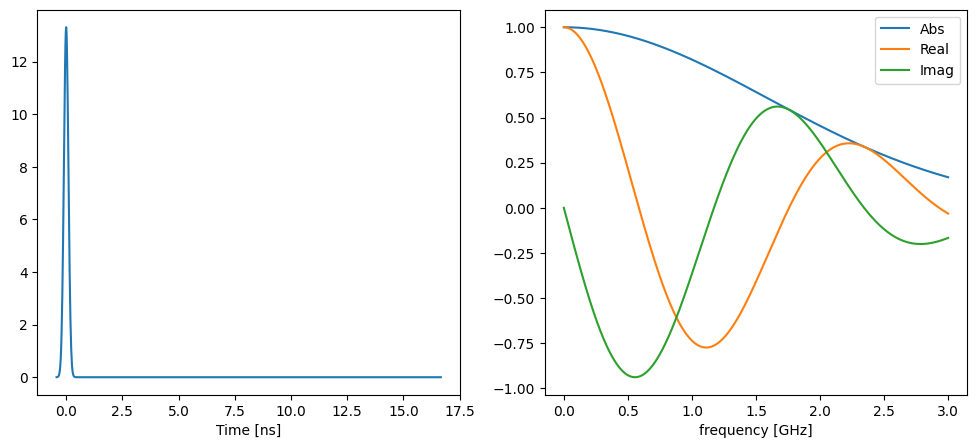

In [11]:
# Function that will be deconvolved under the hood!
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sigma = 1e-10
data_time = data_wake_time
lambdas = (
    1
    / (sigma * np.sqrt(2 * np.pi))
    * np.exp(-(data_time**2) / (2 * sigma**2))
    / c_light
)

axs[0].plot(data_time * 1e9, lambdas, label="charge distribution")
axs[0].set_xlabel("Time [ns]")

ff, lambadf = iddefix.compute_fft(data_time, lambdas)
axs[1].plot(ff / 1e9, np.abs(lambadf), label="Abs")
axs[1].plot(ff / 1e9, np.real(lambadf), label="Real")
axs[1].plot(ff / 1e9, np.imag(lambadf), label="Imag")
axs[1].legend()
axs[1].set_xlabel("frequency [GHz]")

We can now use the deconvolution to observe the impedance and find the number of resonators. Notice how the impedance changes in the high frequency range due to the deconvolution:

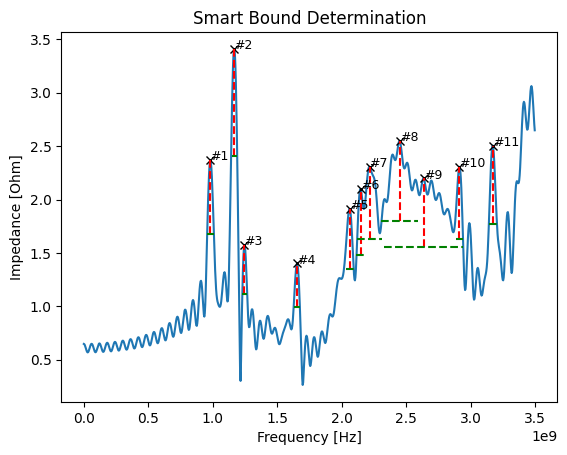

In [12]:
f, Z = iddefix.compute_deconvolution(
    data_wake_time, data_wake_dipolar, sigma=sigma, fmax=3.5e9
)

heights = np.zeros_like(Z)
heights[f < 1.5e9] = 1.5
heights[f >= 1.5e9] = 1.0
heights[f >= 1.8e9] = 1.5
heights[f >= 2.3e9] = 2.5
heights[f >= 2.6e9] = 2.18
heights[f >= 2.7e9] = 2.3
heights[f >= 3.0e9] = 2.4
heights[f >= 3.2e9] = 100
bounds = iddefix.SmartBoundDetermination(f, np.abs(Z), minimum_peak_height=heights)
bounds.inspect()

### Decimate the data to improve speed

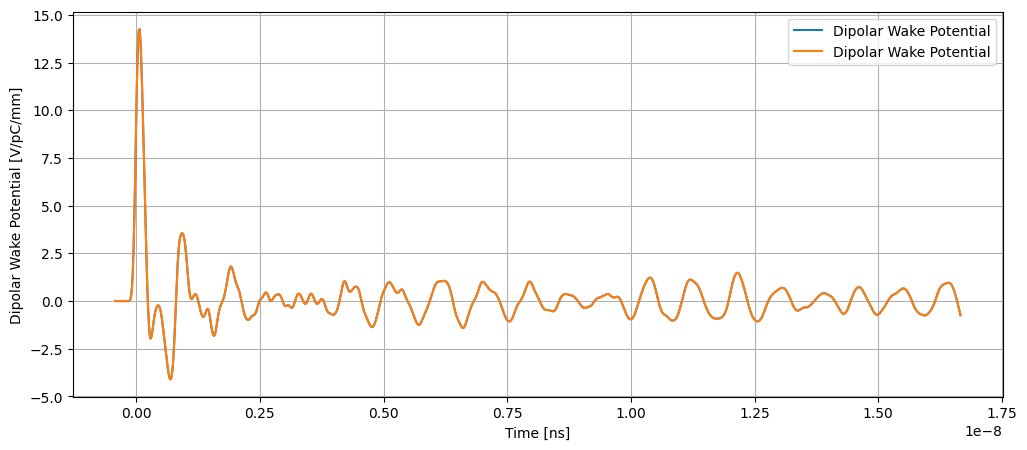

In [26]:
# Decimate wake data
x = np.linspace(data_wake_time[0], data_wake_time[-1], 1000)
y = np.interp(x, data_wake_time, data_wake_dipolar)

# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Plot data_wake_time vs data_wake_dipolar on the left
ax.plot(data_wake_time, data_wake_dipolar, label="Dipolar Wake Potential")
ax.plot(x, y, label="Dipolar Wake Potential")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Dipolar Wake Potential [V/pC/mm]")
ax.grid(True)
ax.legend()

data_wake_time = x
data_wake_dipolar = y

In [14]:
%%time
DE_model = iddefix.EvolutionaryAlgorithm(
    data_wake_time,
    data_wake_dipolar * c_light,  # remove normalization
    N_resonators=bounds.N_resonators,
    parameterBounds=bounds.parameterBounds,
    plane="transverse",
    fitFunction="wake potential",
    sigma=sigma,
    objectiveFunction=iddefix.ObjectiveFunctions.sumOfSquaredErrorReal,
)

DE_model.run_differential_evolution(
    maxiter=2000, popsize=180, tol=0.001, mutation=(0.1, 0.5), crossover_rate=0.8
)
print(DE_model.warning)

Optimization Progress %: 100.87806502809275it [11:37,  6.91s/it]                              



----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.03e+00        |      83.87       |    9.918e+08     
    2     |        7.95e+00        |      150.28      |    1.176e+09     
    3     |        1.26e+00        |      17.10       |    1.254e+09     
    4     |        1.13e+00        |      36.28       |    1.655e+09     
    5     |        1.55e+00        |      175.32      |    2.070e+09     
    6     |        1.68e+00        |      162.45      |    2.156e+09     
    7     |        1.85e+00        |      55.71       |    2.225e+09     
    8     |        2.05e+00        |      42.97       |    2.442e+09     
    9     |        1.81e+00        |       5.00       |    2.644e+09     
    10    |        2.05e+00        |      188.87      |    2.909e+09     
    11    |        2.01e+00        |      

In [15]:
DE_model.run_minimization_algorithm()

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.22e+00        |      75.53       |    1.005e+09     
    2     |        8.70e+00        |      161.35      |    1.176e+09     
    3     |        1.14e+00        |      15.39       |    1.269e+09     
    4     |        1.05e+00        |      36.20       |    1.656e+09     
    5     |        1.70e+00        |      183.33      |    2.075e+09     
    6     |        1.52e+00        |      173.31      |    2.194e+09     
    7     |        1.67e+00        |      52.78       |    2.248e+09     
    8     |        1.84e+00        |      44.76       |    2.431e+09     
    9     |        1.86e+00        |       4.82       |    2.671e+09     
    10    |        1.88e+00        |      177.15      |    2.908e+09     
    

### Showing the results:

With the parameters computed by `iddefix` evolutionary algorithm, we can generate analytcally the wake potential and compare it to the original data:

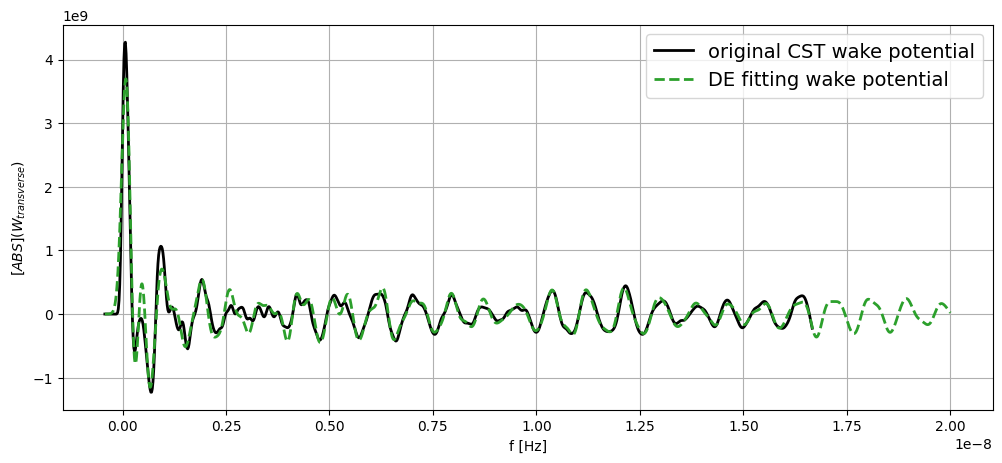

In [21]:
time = np.linspace(data_wake_time[0], 20e-9, 10000)
fig, ax0 = plt.subplots(1, 1, figsize=(12, 5))

ax0.plot(
    DE_model.time_data,
    DE_model.wake_potential_data,
    lw=2,
    c="k",
    label="original CST wake potential",
)

ax0.plot(
    time,
    DE_model.get_wake_potential(time, sigma=1e-10),
    lw=2,
    c="tab:green",
    linestyle="--",
    label="DE fitting wake potential",
)

ax0.set_xlabel("f [Hz]")
ax0.set_ylabel("$[ABS](W_{transverse})$")
ax0.legend(loc="best", fontsize=14)
ax0.grid()

We can also compute analytically the wake funciton from the parameters, and compare it to the wake potential. This differences are important for beam dynamic simulations, since the beam dynamic codes take as input the wake functions and not wake potentials!

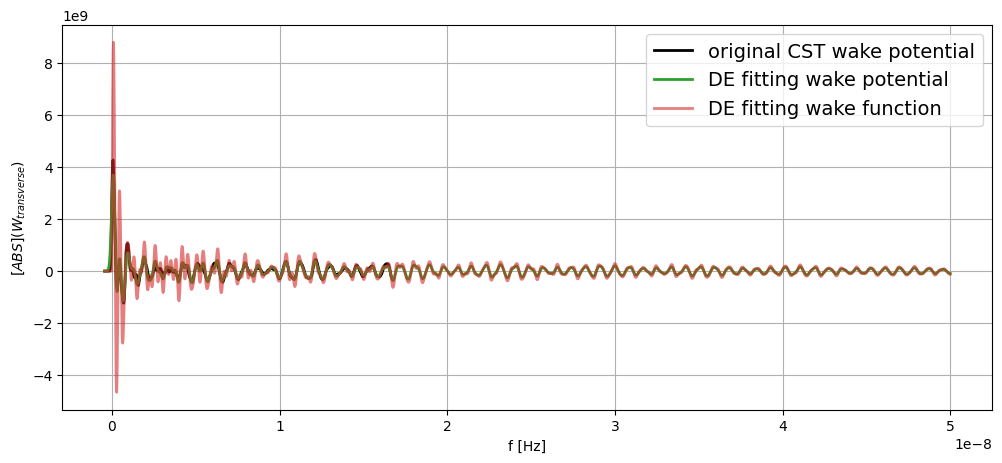

In [22]:
time = np.linspace(data_wake_time[0], 50e-9, 10000)
fig, ax0 = plt.subplots(1, 1, figsize=(12, 5))

ax0.plot(
    data_wake_time,
    data_wake_dipolar * c_light,
    lw=2,
    c="k",
    label="original CST wake potential",
)

ax0.plot(
    time,
    DE_model.get_wake_potential(time, sigma=1e-10),
    lw=2,
    c="tab:green",
    linestyle="-",
    label="DE fitting wake potential",
)
ax0.plot(
    time,
    DE_model.get_wake(time),
    lw=2,
    c="tab:red",
    linestyle="-",
    label="DE fitting wake function",
    alpha=0.6,
)

ax0.set_xlabel("f [Hz]")
ax0.set_ylabel("$[ABS](W_{transverse})$")
ax0.legend(loc="best", fontsize=14)
ax0.grid()

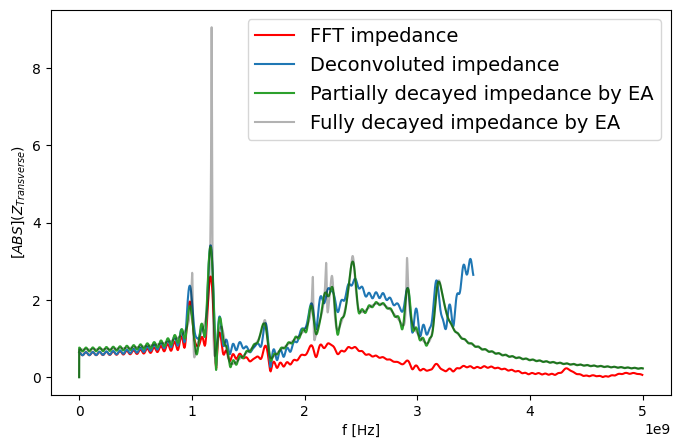

In [23]:
ff, Zz = iddefix.compute_fft(data_wake_time, data_wake_dipolar, fmax=5e9)

f_fd = np.linspace(0, 5e9, 10000)
Z_pd = DE_model.get_impedance(frequency_data=f_fd, wakelength=data_time[-1] * c_light)
Z_fd = DE_model.get_impedance(frequency_data=f_fd, wakelength=None)

# Compare magnitude [ABS]
plt.figure(figsize=(8, 5))
plt.plot(ff, np.abs(Zz), c="r", label="FFT impedance")
plt.plot(f, np.abs(Z), c="tab:blue", label="Deconvoluted impedance")
plt.plot(
    f_fd, np.abs(Z_pd), color="tab:green", label="Partially decayed impedance by EA"
)
plt.plot(
    f_fd, np.abs(Z_fd), color="k", alpha=0.3, label="Fully decayed impedance by EA"
)
plt.legend()
plt.xlabel("f [Hz]")
plt.ylabel("$[ABS](Z_{Transverse})$")
plt.legend(loc="best", fontsize=14)

Text(0, 0.5, '$Z_{Transverse}$')

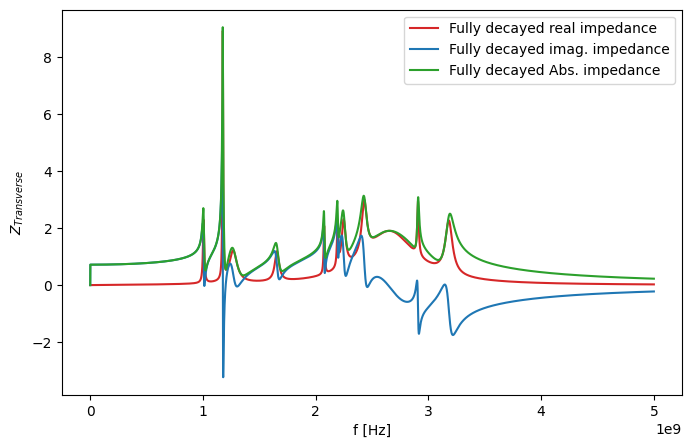

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(f_fd, np.real(Z_fd), color="tab:red", label="Fully decayed real impedance")
plt.plot(f_fd, np.imag(Z_fd), color="tab:blue", label="Fully decayed imag. impedance")
plt.plot(f_fd, np.abs(Z_fd), color="tab:green", label="Fully decayed Abs. impedance")
plt.legend()
plt.xlabel("f [Hz]")
plt.ylabel("$Z_{Transverse}$")